# Inverse Gamma fixed step size simulations for barrier option

In [47]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import linregress

def BM(T, N):
#Define time discretization
    h = T/N
    h_fine = h/16
    t = np.arange(0, T+h, h)
    t_fine = np.arange(0, T+h_fine, h_fine)

# Generate the fine Brownian incements and path
    W_fine = np.zeros(16*N+1)
    dW_fine = np.zeros(16*N)
    W_fine[0]= 0
    for i in range(16*N):
        dW_fine[i] = np.random.normal(0, np.sqrt(h_fine))
        W_fine[i+1] = W_fine[i] + dW_fine[i]

# Define the crude Brownian increments
    dW_crude = np.zeros(N)
    for i in range(N):
        dW_crude[i] = np.sum(dW_fine[16*i:16*(i+1)])

    BMoutputs = {
        'step size': h,
        'fine step size': h_fine,
        'num steps': N,
        'fine delta W': dW_fine, 
        'crude delta W': dW_crude
    }
    return BMoutputs

## Specify parameters

In [48]:
a = 4.19
b = 0.0639
sigma = 1.71
mu = 0.0259

B = 0.99
K = 0.96

a_tilde = a + (sigma**2)/2
b_tilde = (2*a*b)/(2*a + sigma**2)

#specify the initial condition (Y is V)
U_0 = np.log(0.9335)
Y_0 = 0.0649

constants = {
    'a': a, 
    'b': b, 
    'vol': sigma, 
    'drift': mu,
    'a tilde': a_tilde, 
    'b tilde': b_tilde,
    'IV U': U_0,
    'IV V': Y_0,
    'barrier': B,
    'strike': K
}


### Euler Maruyama

In [49]:
def euler(BMoutputs1, BMoutputs2, constants):
    a = constants['a']
    b = constants['b']
    sigma = constants['vol']
    mu = constants['drift']
    U_0 = constants['IV U']
    Y_0 = constants['IV V']
    B = constants['barrier']
    K = constants['strike']

    h = BMoutputs1['step size']
    h_fine = BMoutputs1['fine step size']
    N = BMoutputs1['num steps']
    dW_fine1 = BMoutputs1['fine delta W']
    dW_crude1 = BMoutputs1['crude delta W']
    dW_fine2 = BMoutputs2['fine delta W']
    dW_crude2 = BMoutputs2['crude delta W']

    hit = 0
    hit_fine = 0

    #Initialize the outputs
    U= np.zeros(N+1)
    U[0] = U_0
    U_fine = np.zeros(16*N+1)
    U_fine[0] = U_0

    Y= np.zeros(N+1)
    Y[0] = Y_0
    Y_fine = np.zeros(16*N+1)
    Y_fine[0] = Y_0

    #compute the crude Euler Maruyama approximations
    for i in range(N):
        if np.exp(U[i]) < B:
            Y[i+1] = Y[i] + a*(b - Y[i])*h + sigma*Y[i]*dW_crude2[i]
            U[i+1] = U[i] + (mu - (1/2)*(Y[i]**2))*h + Y[i]*dW_crude1[i]
        else:
            hit = 1
            break

    #compute the fine Euler Maruyama approximations
    for i in range(16*N):
        if np.exp(U_fine[i]) < B:
            Y_fine[i+1] = Y_fine[i] + a*(b - Y_fine[i])*h_fine + sigma*Y_fine[i]*dW_fine2[i]
            U_fine[i+1] = U_fine[i] + (mu - (1/2)*(Y_fine[i]**2))*h_fine + Y_fine[i]*dW_fine1[i]
        else:
            hit_fine = 1
            break

    #compute the error terms
    if hit == 1:
        e_N = 0
    else:
        e_N = max(0, np.exp(U[-1])-K)
    
    if hit_fine == 1:
        e_N_fine = 0
    else:
        e_N_fine = max(0, np.exp(U_fine[-1])-K)
    return e_N, e_N_fine


### Milstein

In [50]:
def milstein(BMoutputs1, BMoutputs2, constants):
    a_tilde = constants['a tilde']
    b_tilde = constants['b tilde']
    sigma = constants['vol']
    mu = constants['drift']
    B = constants['barrier']
    K = constants['strike']
    
    U_0 = constants['IV U']
    Y_0 = constants['IV V']

    h = BMoutputs1['step size']
    h_fine = BMoutputs1['fine step size']
    N = BMoutputs1['num steps']
    dW_fine1 = BMoutputs1['fine delta W']
    dW_crude1 = BMoutputs1['crude delta W']
    dW_fine2 = BMoutputs2['fine delta W']
    dW_crude2 = BMoutputs2['crude delta W']

    hit = 0
    hit_fine = 0

    #Initialize the outputs
    U= np.zeros(N+1)
    U[0] = U_0
    U_fine = np.zeros(16*N+1)
    U_fine[0] = U_0

    Y= np.zeros(N+1)
    Y[0] = Y_0
    Y_fine = np.zeros(16*N+1)
    Y_fine[0] = Y_0


    #compute the crude Milstein approximations
    for i in range(N):
        if np.exp(U[i]) < B:
            Y[i+1] = Y[i] + a_tilde*(b_tilde - Y[i])*h + sigma*Y[i]*dW_crude2[i] + (1/2)*(sigma**2)*Y[i]*((dW_crude2[i])**2)
            U[i+1] = U[i] + (mu - (1/2)*(Y[i]**2))*h + Y[i]*dW_crude1[i] + (1/2)*sigma*Y[i]*dW_crude1[i]*dW_crude2[i]
        else:
            hit = 1
            break
    
    #compute the fine Milstein approximations
    for i in range(16*N):
        if np.exp(U_fine[i]) < B:
            Y_fine[i+1] = Y_fine[i] + a_tilde*(b_tilde - Y_fine[i])*h_fine + sigma*Y_fine[i]*dW_fine2[i] + (1/2)*(sigma**2)*Y_fine[i]*((dW_fine2[i])**2)
            U_fine[i+1] = U_fine[i] + (mu - (1/2)*(Y_fine[i]**2))*h_fine + Y_fine[i]*dW_fine1[i] + (1/2)*sigma*Y_fine[i]*dW_fine1[i]*dW_fine2[i]
        else:
            hit_fine = 1
            break
        
    #compute the error term
    if hit == 1:
        e_N = 0
    else:
        e_N = max(0, np.exp(U[-1])-K)
    
    if hit_fine == 1:
        e_N_fine = 0
    else:
        e_N_fine = max(0, np.exp(U_fine[-1])-K)
    return e_N, e_N_fine

### Heun's

In [51]:
def heun(BMoutputs1, BMoutputs2, constants):
    a_tilde = constants['a tilde']
    b_tilde = constants['b tilde']
    sigma = constants['vol']
    mu = constants['drift']
    B = constants['barrier']
    K = constants['strike']
    
    U_0 = constants['IV U']
    Y_0 = constants['IV V']

    h = BMoutputs1['step size']
    h_fine = BMoutputs1['fine step size']
    N = BMoutputs1['num steps']
    dW_fine1 = BMoutputs1['fine delta W']
    dW_crude1 = BMoutputs1['crude delta W']
    dW_fine2 = BMoutputs2['fine delta W']
    dW_crude2 = BMoutputs2['crude delta W']

    hit = 0
    hit_fine = 0

    #Initialize the outputs
    U= np.zeros(N+1)
    U[0] = U_0
    U_fine = np.zeros(16*N+1)
    U_fine[0] = U_0

    Y= np.zeros(N+1)
    Y[0] = Y_0
    Y_tilde = np.zeros(N+1)
    Y_fine = np.zeros(16*N+1)
    Y_fine[0] = Y_0
    Y_fine_tilde = np.zeros(16*N+1)

    #compute the crude Heun's approximations
    for i in range(N):
        if np.exp(U[i]) < B:
            Y_tilde[i] = Y[i] + h*a_tilde*(b_tilde - Y[i]) + sigma*Y[i]*dW_crude2[i]
            Y[i+1] = Y[i] + (1/2)*h*(a_tilde*(b_tilde - Y[i]) + a_tilde*(b_tilde - Y_tilde[i])) + (1/2)*(sigma*Y[i] + sigma*Y_tilde[i])*dW_crude2[i]
            U[i+1] = U[i] + (mu - (1/4)*(Y[i]**2) - (1/4)*(Y_tilde[i]**2))*h + (1/2)*(Y[i] + Y_tilde[i])*dW_crude1[i]
        else:
            hit = 1
            break
    #compute the fine Heun's approximations
    for i in range(16*N):
        if np.exp(U_fine[i]) < B:
            Y_fine_tilde[i] = Y_fine[i] + h_fine*a_tilde*(b_tilde - Y_fine[i]) + sigma*Y_fine[i]*dW_fine2[i]
            Y_fine[i+1] = Y_fine[i] + (1/2)*h_fine*(a_tilde*(b_tilde - Y_fine[i]) + a_tilde*(b_tilde - Y_fine_tilde[i])) + (1/2)*(sigma*Y_fine[i] + sigma*Y_fine_tilde[i])*dW_fine2[i]
            U_fine[i+1] = U_fine[i] + (mu - (1/4)*(Y_fine[i]**2) - (1/4)*(Y_fine_tilde[i]**2))*h_fine + (1/2)*(Y_fine[i] + Y_fine_tilde[i])*dW_fine1[i]
        else:
            hit_fine = 1
            break
    #compute the error term
    if hit == 1:
        e_N = 0
    else:
        e_N = max(0, np.exp(U[-1])-K)
    
    if hit_fine == 1:
        e_N_fine = 0
    else:
        e_N_fine = max(0, np.exp(U_fine[-1])-K)
    return e_N, e_N_fine


#### sampling and error calculations

In [55]:
# Initialize lists to store errors and step sizes as numpy arrays
EM_errors_weak = np.array([])
Mil_errors_weak = np.array([])
Heun_errors_weak = np.array([])
step_sizes = np.array([])
no_samples = 10000
T = 1
for N in [2, 10, 25, 50, 100, 200]:
    step_sizes =  np.append(step_sizes, T/N)
    n=1
    EM_errors = np.array([])
    Mil_errors = np.array([])
    Heun_errors = np.array([])
    EM_errors_fine = np.array([])
    Mil_errors_fine = np.array([])
    Heun_errors_fine = np.array([])
    for i in tqdm(range(no_samples)):
        BMoutputs1 = BM(T, N)
        BMoutputs2 = BM(T, N)

        EM_error, EM_error_fine = euler(BMoutputs1, BMoutputs2, constants)
        Mil_error, Mil_error_fine = milstein(BMoutputs1, BMoutputs2, constants)
        Heun_error, Heun_error_fine = heun(BMoutputs1, BMoutputs2, constants)

        EM_errors = np.append(EM_errors, EM_error)
        Mil_errors = np.append(Mil_errors, Mil_error)
        Heun_errors = np.append(Heun_errors, Heun_error)
        EM_errors_fine = np.append(EM_errors_fine, EM_error_fine)
        Mil_errors_fine = np.append(Mil_errors_fine, Mil_error_fine)
        Heun_errors_fine = np.append(Heun_errors_fine, Heun_error_fine)

    EM_mean = (np.sum(EM_errors))/no_samples
    EM_mean_fine = (np.sum(EM_errors_fine))/no_samples
    EM_weak = np.abs(EM_mean - EM_mean_fine)
    EM_errors_weak = np.append(EM_errors_weak, EM_weak)
    
    Mil_mean = (np.sum(Mil_errors))/no_samples
    Mil_mean_fine = (np.sum(Mil_errors_fine))/no_samples
    Mil_weak = np.abs(Mil_mean - Mil_mean_fine)
    Mil_errors_weak = np.append(Mil_errors_weak, Mil_weak)

    Heun_mean = (np.sum(Heun_errors))/no_samples
    Heun_mean_fine = (np.sum(Heun_errors_fine))/no_samples
    Heun_weak = np.abs(Heun_mean - Heun_mean_fine)
    Heun_errors_weak = np.append(Heun_errors_weak, Heun_weak)




100%|██████████| 10000/10000 [11:18<00:00, 14.74it/s]


### plot

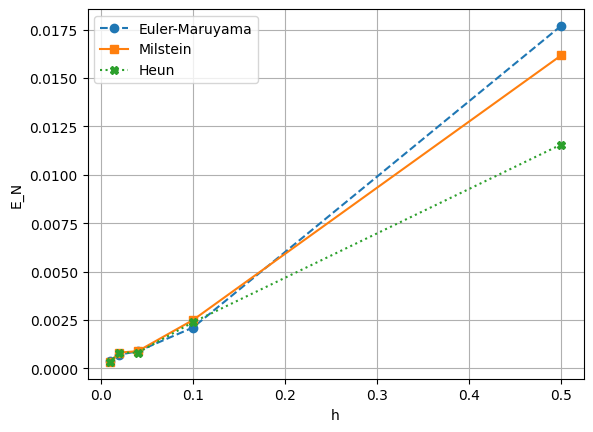

Euler-Maruyama Fit: Slope = 0.03595144382506337 , Intercept = -0.00046399833301709846
Milstein Fit: Slope = 0.03259795392574335 , Intercept = -0.0002327624601655108
Heun Fit: Slope = 0.022874394752097613 , Intercept = 0.00011151791077220656


In [53]:

# Assuming you have step_sizes, EM_errors, Mil_errors, and Heun_errors defined

# Perform linear regression

slope_EM, intercept_EM, _, _, _ = linregress(step_sizes, EM_errors_weak)
slope_Mil, intercept_Mil, _, _, _ = linregress(step_sizes, Mil_errors_weak)
slope_Heun, intercept_Heun, _, _, _ = linregress(step_sizes, Heun_errors_weak)

# Plot the best-fit lines

plt.plot(step_sizes, EM_errors_weak, label='Euler-Maruyama', linestyle='--', marker="o")
plt.plot(step_sizes, Mil_errors_weak, label='Milstein', linestyle='-', marker="s")
plt.plot(step_sizes, Heun_errors_weak, label='Heun', linestyle='dotted', marker="X")

plt.xlabel('h')
plt.ylabel('E_N')
plt.legend()
plt.grid(True)
#plt.xlim(0, 2.5)
#plt.ylim(1, 4.5)
plt.show()

print("Euler-Maruyama Fit: Slope =", slope_EM, ", Intercept =", intercept_EM)
print("Milstein Fit: Slope =", slope_Mil, ", Intercept =", intercept_Mil)
print("Heun Fit: Slope =", slope_Heun, ", Intercept =", intercept_Heun)

### plot log

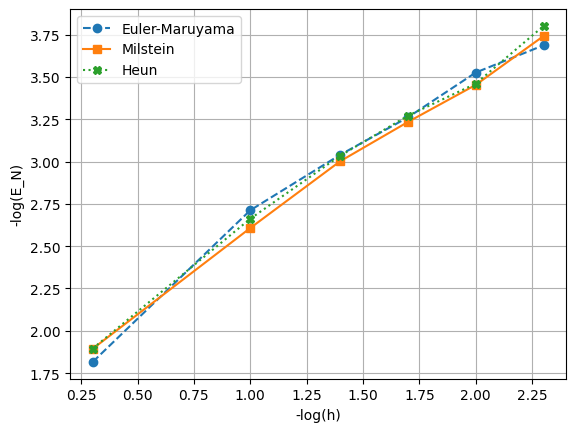

Euler-Maruyama Fit: Slope = 0.9280536180433882 , Intercept = 1.6612214431595826
Milstein Fit: Slope = 0.9126275261438883 , Intercept = 1.665178670110883
Heun Fit: Slope = 0.926299413046196 , Intercept = 1.677375519280463


In [56]:
# Calculate logarithm base 10 of step sizes and errors
log_step_sizes = -np.log10(step_sizes)
log_EM_errors = -np.log10(EM_errors_weak)
log_Mil_errors = -np.log10(Mil_errors_weak)
log_Heun_errors = -np.log10(Heun_errors_weak)
# Perform linear regression
slope_EM, intercept_EM, _, _, _ = linregress(log_step_sizes, log_EM_errors)
slope_Mil, intercept_Mil, _, _, _ = linregress(log_step_sizes, log_Mil_errors)
slope_Heun, intercept_Heun, _, _, _ = linregress(log_step_sizes, log_Heun_errors)
plt.plot(log_step_sizes, log_EM_errors, label='Euler-Maruyama', linestyle='--', marker="o")
plt.plot(log_step_sizes, log_Mil_errors, label='Milstein', linestyle='-', marker="s")
plt.plot(log_step_sizes, log_Heun_errors, label='Heun', linestyle='dotted', marker="X")

plt.xlabel('-log(h)')
plt.ylabel('-log(E_N)')
plt.legend()
plt.grid(True)
#plt.xlim(0, 2.5)
#plt.ylim(1, 4.5)
plt.show()

print("Euler-Maruyama Fit: Slope =", slope_EM, ", Intercept =", intercept_EM)
print("Milstein Fit: Slope =", slope_Mil, ", Intercept =", intercept_Mil)
print("Heun Fit: Slope =", slope_Heun, ", Intercept =", intercept_Heun)